## Algoritmo de Maximización de la Esperanza
#### Estudiantes: Dennis Luna Acuña- Graciela Rivera Picado - Luis E. Vargas Porras

### Libraries

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

import scipy
from scipy.stats import entropy
from scipy.stats import norm
from torch.distributions import normal
from torch.distributions import multivariate_normal
from scipy import stats 
import seaborn as sns 

#from sklearn.cluster import KMeans
#"from sklearn import metrics
#from scipy.spatial.distance import cdist

from scipy.special import logsumexp

### 1. Generate data with Gaussian distribution

*The data are artificially created with a 2-cluster Gaussian distribution with specific means and variances.*

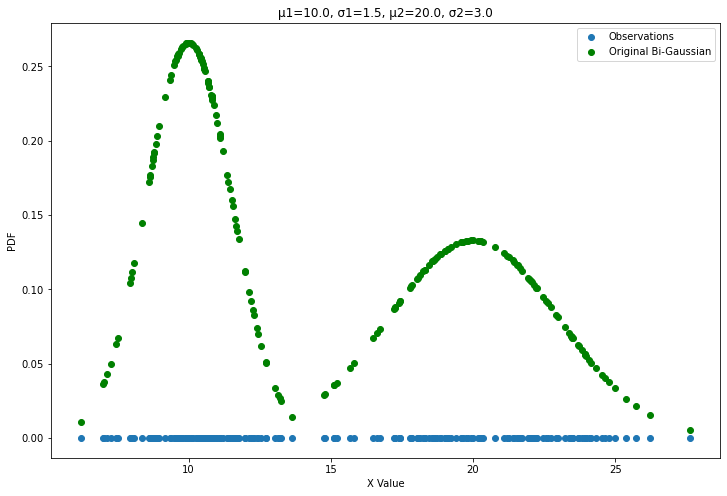

In [10]:
def createDataOneClass(means, std, numberSamplesPerClass):
    normal_dist = torch.distributions.Normal(means,std)
    gaussian_sample = normal_dist.sample((numberSamplesPerClass,1)).squeeze()
    
    return gaussian_sample


def generate_data(numberSamplesPerClass, mean1, mean2 , stds1 , stds2 ):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2    """

    samplesClass1 = createDataOneClass(mean1, stds1, numberSamplesPerClass)
    samplesClass2 = createDataOneClass(mean2, stds2, numberSamplesPerClass)
    #Concatenates
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    # Plot Data
    y = np.zeros_like(samplesAll)
    plt.figure(figsize=(12,8)) 
    plt.scatter(samplesAll, y, label='Observations')
    #plt.title('Plotting)
    plt.xlabel('X Value')
    plt.ylabel('PDF')
    
    plt.title("µ1=%s, σ1=%s, µ2=%s, σ2=%s"%(mean1, stds1, mean2, stds2))
    plt.xlabel('X Value')
    plt.ylabel('PDF')


    #Plot densities Functions
    plt.scatter(samplesClass1, norm.pdf(samplesClass1, mean1, stds1), color="green", label='Original Bi-Gaussian')
    plt.scatter(samplesClass2, norm.pdf(samplesClass2, mean2, stds2), color="green")
    plt.legend()
    plt.show()

    
    return (samplesAll, samplesClass1, samplesClass2)

'''
Creates data with gaussian distribution
'''

#Call Function generate Data
X_allSamples, X1_samples, X2_samples = generate_data(numberSamplesPerClass=100, mean1=10.0, mean2=20.0, stds1=1.5, stds2=3.0)



### 2. Create init_random_parameters

In [11]:
def init_random_parameters(K=2, range_mean = [1,10], range_std = [1,5]):
      
    # Se pasan por por parámetro el rango donde se elegiran de manera aleatoria los valores. 
    # K2 corresponde a la forma matricial para el acomodo de los elementos, en este caso las columna 0 de la matriz
    # corresponden a los means y la columna 1 a los sigma. 
    
    
    mean = torch.randint(range_mean[0],range_mean[1],(K,1))   # Creación de arreglo de tensores que contiene los means o mu
    std  = torch.randint(range_std[0], range_std[1],(K,1))    # Creación de arreglo de tensores que contiene los sigma

    
    W = torch.cat((mean, std), 1)
    
    g= W.numpy()  
    
    # Se procede a realizar la graficación para comprobar su funcionamiento
    
    #numberSamplesPerClass=100
    #mean1=g[0,0]
    #mean2=g[1,0]
    #stds1=g[0,1]
    #stds2=g[1,1]
    
    #samplesClass1 = createDataOneClass(mean1, stds1, numberSamplesPerClass)
    #samplesClass2 = createDataOneClass(mean2, stds2, numberSamplesPerClass)
    #Concatenates
    #samplesAll = torch.cat((samplesClass1, samplesClass2), 0)

    
    
    #y = np.zeros_like(samplesAll)
    #plt.figure(figsize=(12,8)) 
          
    #plt.scatter(samplesAll, y, marker='.', label="Observations")
    #mu1 = round(g[0,0].item(),2)
    #mu2 = round(g[1,0].item(),2)
    #sig1 = round(g[0,1].item(),2)
    #sig2 = round(g[1,1].item(),2)

    #plt.title("µ1=%s, σ1=%s, µ2=%s, σ2=%s"%(mu1, sig1, mu2, sig2))
    #plt.xlabel('X Value')
    #plt.ylabel('PDF')

    #Plot densities Functions
    #plt.scatter(samplesClass1, norm.pdf(samplesClass1, mean1, stds1), color='green', label='Original Bi-Gaussian')
    #plt.scatter(samplesClass2, norm.pdf(samplesClass2, mean2, stds2), color='green') 
 
    #plt.legend()
    #plt.show()
    
    
    return W

#Test

W_parameters = init_random_parameters(K=2, range_mean = [1,50], range_std = [1,10])
W_parameters


tensor([[25,  9],
        [20,  1]])

### 3. Likelihood Gaussian Observation Function

In [12]:
# Likelihood sin inserción de logaritmo
def calculate_likelihood_gaussian_observation(x_n,mu_k,sigma_k):
    
    p_x1 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k[0]))) * np.exp(-0.5*((x_n-mu_k[0])/sigma_k[0])**2)
    p_x2 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k[1]))) * np.exp(-0.5*((x_n-mu_k[1])/sigma_k[1])**2) 
    #p_xAll = torch.Tensor([p_x1,p_x2])
    return p_x1,p_x2
    
calculate_likelihood_gaussian_observation(X_allSamples[0], mu_k = [10,20], sigma_k = [1.5,3])

(tensor(0.3224), tensor(0.0007))

In [13]:
# Likelihood con  inserción de logaritmo
def calculate_likelihood_gaussian_observationLOG(x_n,mu_k,sigma_k):
    
    p_x1 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k[0]))) * np.exp(-0.5*((x_n-mu_k[0])/sigma_k[0])**2)
    logp_x1= np.log(p_x1)
    
    p_x2 = prob_density = (1/np.sqrt((2.0*np.pi*sigma_k[1]))) * np.exp(-0.5*((x_n-mu_k[1])/sigma_k[1])**2)
    logp_x2 =  np.log(p_x2)
    
    return logp_x1,logp_x2

calculate_likelihood_gaussian_observationLOG(X_allSamples[0], mu_k = [10,20], sigma_k = [1.5,3])


(tensor(-1.1321), tensor(-7.2668))

In [14]:
# Conclusión, para efectos de los datos se determina utilizar likelihood sin logaritmo.

### 4. Calculate_membership

In [15]:
def calculate_membership_dataset(X_dataset,Parameters_matrix):
    #crear una matriz con ceros
    N = len(X_dataset)
    k = 2
    M = torch.zeros((N, k))
    
    #calculate_likelihood
    likelihood1,likelihood2 = calculate_likelihood_gaussian_observation(X_dataset,Parameters_matrix[:,0],Parameters_matrix[:,1])
    
    #print("likelihood2:", likelihood2.reshape([N, 1]))
    likelihoodALL = torch.cat((likelihood1.reshape([N, 1]), likelihood2.reshape([N, 1])), 1)
    
    M[:,0] = likelihoodALL[:,0] > likelihoodALL[:,1] 
    M[:,1] = likelihoodALL[:,0] < likelihoodALL[:,1] 
    
    return M

#fix_param = torch.tensor([[10,1.5],[20,3]])

Membership_Matrix = calculate_membership_dataset(X_allSamples,W_parameters)


## 5. Recalculate_parameters

In [16]:
def recalculate_parameters(X_dataset,Membership_data): 
    
    N = len(X_dataset)   
    
    X1 = torch.cat((X_dataset.reshape([N, 1]),Membership_data[:,0].reshape([N, 1])),1)
    X2 = torch.cat((X_dataset.reshape([N, 1]),Membership_data[:,1].reshape([N, 1])),1)
    
    X1_filtrada = X1[X1[:,1] == 1][:,0]
    X2_filtrada = X2[X2[:,1] == 1][:,0]
    
    mu_x1 = torch.mean(X1_filtrada)
    mu_x2 = torch.mean(X2_filtrada)
    
    sigma_x1 = torch.std(X1_filtrada)
    sigma_x2 = torch.std(X2_filtrada)
    
    new_W = torch.tensor([[mu_x1,sigma_x1],[mu_x2,sigma_x2]])
  
    return new_W
    
recalculate_parameters(X_allSamples,Membership_Matrix)


#NOTA SI EL RESULTADO DEL RECALCULO DE PARAMETROS ES NAN EJECUTAR NUEVAMENTE EL PROGRAMA
    

tensor([[14.6001,  5.8353],
        [19.7043,  0.9255]])

### 6. Corridas del Algoritmo

Iteration number: 1
Parameters values used: tensor([[22,  7],
        [11,  3]])

Iteration number: 2
Parameters values used: tensor([[20.7326,  2.8351],
        [10.3611,  1.6671]])

Iteration number: 3
Parameters values used: tensor([[20.6122,  2.9298],
        [10.2737,  1.5613]])

Iteration number: 4
Parameters values used: tensor([[20.6122,  2.9298],
        [10.2737,  1.5613]])

Iteration number: 5
Parameters values used: tensor([[20.6122,  2.9298],
        [10.2737,  1.5613]])

Iteration number: 6
Parameters values used: tensor([[20.6122,  2.9298],
        [10.2737,  1.5613]])

Iteration number: 7
Parameters values used: tensor([[20.6122,  2.9298],
        [10.2737,  1.5613]])

Iteration number: 8
Parameters values used: tensor([[20.6122,  2.9298],
        [10.2737,  1.5613]])

Iteration number: 9
Parameters values used: tensor([[20.6122,  2.9298],
        [10.2737,  1.5613]])

Iteration number: 10
Parameters values used: tensor([[20.6122,  2.9298],
        [10.2737,  1.5613]])


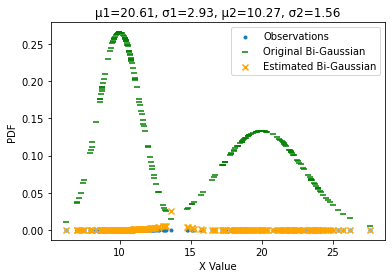

In [33]:
initialize_type=True

def corridas_iteraciones():
   
    #global W_parameters
    global X_allSamples
    
    W_parameters = init_random_parameters(K=2, range_mean = [1,50], range_std = [1,10])
    
    if initialize_type==False:
        
        W_parameters_h=m_step(X_allSamples,W_parameters)    # En caso de correr la nueva heuristica con los parametros iniciales
    
       
    for i in range(1,21):
        print("Iteration number: %s"%i)
        
            
        print("Parameters values used: %s\n"%W_parameters)

        if initialize_type == True:
            new_M = calculate_membership_dataset(X_allSamples,W_parameters)
            W_parameters = recalculate_parameters(X_allSamples,new_M)
        
        if initialize_type == False:
            new_M = calculate_membership_dataset(X_allSamples,W_parameters_h)
            W_parameters = recalculate_parameters(X_allSamples,new_M)
            
            
        if(i==4 or i==9 or i==19):
            # Plot Data
            y = np.zeros_like(X_allSamples)
            #plt.figure(figsize=(12,8))
            plt.scatter(X_allSamples, y, marker='.', label="Observations")
            mu1 = round(W_parameters[0,0].item(),2)
            mu2 = round(W_parameters[1,0].item(),2)
            sig1 = round(W_parameters[0,1].item(),2)
            sig2 = round(W_parameters[1,1].item(),2)

            plt.title("µ1=%s, σ1=%s, µ2=%s, σ2=%s"%(mu1, sig1, mu2, sig2))
            plt.xlabel('X Value')
            plt.ylabel('PDF')

            #Plot densities Functions
            plt.scatter(X1_samples, norm.pdf(X1_samples, 10, 1.5), marker='_', color='green', label='Original Bi-Gaussian')
            plt.scatter(X2_samples, norm.pdf(X2_samples, 20, 3), marker='_', color='green') 
            plt.scatter(X1_samples, norm.pdf(X1_samples, W_parameters[0,0], W_parameters[0,1]), marker='x', color='orange', label='Estimated Bi-Gaussian')
            plt.scatter(X2_samples, norm.pdf(X2_samples, W_parameters[1,0], W_parameters[1,1]), marker='x', color='orange')      
            plt.legend()
            #plt.show()
            
            if initialize_type==False:
                plt.savefig("EM_plot_5_%s.svg"%(i+1))
            
            if (i != 19):
                plt.clf()
                
corridas_iteraciones()

### 7. Heurística nueva para la inicialización de parámetros

In [18]:
# Aplicando estrategia técnica mstep

def e_step(x, params):
    
    params=params.numpy()
    x=x.numpy()
    
    np.log([stats.multivariate_normal(params[0,0], params[0,1]).pdf(x),
            stats.multivariate_normal(params[1,0], params[1,1]).pdf(x)])
    
    log_p_y_x = np.log([1])[np.newaxis, ...] + \
                np.log([stats.multivariate_normal(params[0,0], params[0,1]).pdf(x),
            stats.multivariate_normal(params[1,0], params[1,1]).pdf(x)]).T
    
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])

In [19]:
def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    x=x.numpy()
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    
    
    mu0 = torch.from_numpy(mu0)
    mu1 = torch.from_numpy(mu1)

    sigma0= abs(min(sigma0))*10**15
    sigma1= abs(min(sigma1))*10**15
    

    

    new_params=torch.tensor([[mu0,sigma0],[mu1,sigma1]])
        

    return new_params

#W_parameters = init_random_parameters(K=2, range_mean = [1,50], range_std = [1,10])

m_step(X_allSamples,W_parameters)



tensor([[14.1737, 55.4924],
        [19.3995,  4.0917]], dtype=torch.float64)

Iteration number: 1
Parameters values used: tensor([[12,  2],
        [16,  3]])

Iteration number: 2
Parameters values used: tensor([[10.2737,  1.5613],
        [20.6122,  2.9298]])

Iteration number: 3
Parameters values used: tensor([[10.2737,  1.5613],
        [20.6122,  2.9298]])

Iteration number: 4
Parameters values used: tensor([[10.2737,  1.5613],
        [20.6122,  2.9298]])

Iteration number: 5
Parameters values used: tensor([[10.2737,  1.5613],
        [20.6122,  2.9298]])

Iteration number: 6
Parameters values used: tensor([[10.2737,  1.5613],
        [20.6122,  2.9298]])

Iteration number: 7
Parameters values used: tensor([[10.2737,  1.5613],
        [20.6122,  2.9298]])

Iteration number: 8
Parameters values used: tensor([[10.2737,  1.5613],
        [20.6122,  2.9298]])

Iteration number: 9
Parameters values used: tensor([[10.2737,  1.5613],
        [20.6122,  2.9298]])

Iteration number: 10
Parameters values used: tensor([[10.2737,  1.5613],
        [20.6122,  2.9298]])


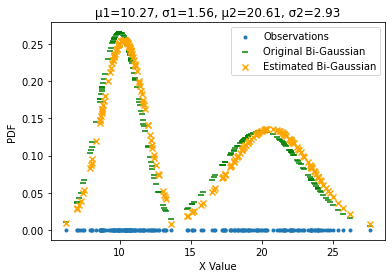

In [60]:
initialize_type=False

corridas_iteraciones()